In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

In [3]:
import PIL
from PIL import Image
import copy
import matplotlib.pyplot as plt

In [4]:
vgg_normalised_conv5_1 = nn.Sequential(
    nn.Conv2d(3,3,(1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,128,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2),(2, 2),(0, 0),ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
)

In [5]:
class Encoder(nn.Module):
    def __init__(self, depth):
        super(Encoder, self).__init__()
        self.depth = depth
        if depth == 1:
            self.model = vgg_normalised_conv5_1[:4]
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_1/vgg_normalised_conv1_1.pth"))
        elif depth == 2:
            self.model = vgg_normalised_conv5_1[:11]
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_2/vgg_normalised_conv2_1.pth"))
        elif depth == 3:
            self.model = vgg_normalised_conv5_1[:18]
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_3/vgg_normalised_conv3_1.pth"))
        elif depth == 4:
            self.model = vgg_normalised_conv5_1[:31]
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_4/vgg_normalised_conv4_1.pth"))

    def forward(self, x):
        out = self.model(x)
        return out

In [6]:
feature_invertor_conv5_1 = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,256,(3, 3)),
    nn.ReLU(),
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,128,(3, 3)),
    nn.ReLU(),
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,64,(3, 3)),
    nn.ReLU(),
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,3,(3, 3)),
)

In [7]:
class Decoder(nn.Module):
    def __init__(self, depth):
        super(Decoder, self).__init__()
        self.depth = depth
        if depth == 1:
            self.model = nn.Sequential(*copy.deepcopy(list(feature_invertor_conv5_1.children())[-2:]))
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_1/feature_invertor_conv1_1.pth"))
        elif depth == 2:
            self.model = nn.Sequential(*copy.deepcopy(list(feature_invertor_conv5_1.children())[-9:]))
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_2/feature_invertor_conv2_1.pth"))
        elif depth == 3:
            self.model = nn.Sequential(*copy.deepcopy(list(feature_invertor_conv5_1.children())[-16:]))
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_3/feature_invertor_conv3_1.pth"))
        elif depth == 4:
            self.model = nn.Sequential(*copy.deepcopy(list(feature_invertor_conv5_1.children())[-29:]))
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_4/feature_invertor_conv4_1.pth"))

    def forward(self, x):
        out = self.model(x)
        return out

In [8]:
def rigid_alignment(cf, sf, alpha=0, beta=0, s1f=None):
    
    # content image
    cf = cf.double()
    c_channels, c_width, c_height = cf.size(0), cf.size(1), cf.size(2)
    zc = cf.view(c_channels, -1)
    
    mean_c = torch.mean(zc, 0)
    mean_c = mean_c.unsqueeze(0).expand_as(zc)
    zc_bar = zc - mean_c
    
    zc_cap = zc_bar/torch.norm(zc_bar)
    
    # style image
    sf = sf.double()
    s_channels, s_width, s_height = sf.size(0), sf.size(1), sf.size(2)
    zs = sf.view(s_channels, -1)
    
    mean_s = torch.mean(zs, 0)
    mean_s = mean_s.unsqueeze(0).expand_as(zs)
    zs_bar = zs - mean_s
    
    zs_cap = zs_bar/torch.norm(zs_bar)
    
    # rotation
    usvt = torch.mm(torch.transpose(zc, 0, 1), zs)
    u, s, v = torch.svd(usvt)
    q = torch.mm(v, torch.transpose(u, 0, 1))
    
    # alignment
    zsc = torch.norm(zc_bar) * torch.mm(zs_cap, q) + mean_c
    z = alpha*zc + (1-alpha)*zsc
    
    if(beta>0):
        
        # style image
        s1f = s1f.double()
        s1_channels, s1_width, s1_height = s1f.size(0), s1f.size(1), s1f.size(2)
        zs1 = s1f.view(s1_channels, -1)

        mean_s1 = torch.mean(zs1, 0)
        mean_s1 = mean_s1.unsqueeze(0).expand_as(zs1)
        zs1_bar = zs1 - mean_s1

        zs1_cap = zs1_bar/torch.norm(zs1_bar)

        # rotation
        us1vt = torch.mm(torch.transpose(zc, 0, 1), zs1)
        u1, s1, v1 = torch.svd(us1vt)
        q1 = torch.mm(v1, torch.transpose(u1, 0, 1))

        # alignment
        zs1c = torch.norm(zc_bar) * torch.mm(zs1_cap, q1) + mean_c
        z = alpha*zc + (1-alpha)*(beta*zs1c + (1-beta)*zsc)
    
    z = torch.reshape(z, (c_channels, c_width, c_height))
    return z.float().unsqueeze(0)

In [9]:
def moment_matching(cf, sf, alpha=0, beta=0, s1f=None):
    
    # content image
    cf = cf.double()
    c_channels, c_width, c_height = cf.size(0), cf.size(1), cf.size(2)
    zc = cf.view(c_channels, -1)
    
    mean_c = torch.mean(zc, 1)
    mean_c = mean_c.unsqueeze(1).expand_as(zc)
    var_c = torch.std(zc, 1).unsqueeze(1).expand_as(zc)
    
    # style image
    sf = sf.double()
    s_channels, s_width, s_height = sf.size(0), sf.size(1), sf.size(2)
    zs = sf.view(s_channels, -1)
    
    mean_s = torch.mean(zs, 1)
    mean_s = mean_s.unsqueeze(1).expand_as(zc)
    var_s = torch.std(zs, 1).unsqueeze(1).expand_as(zc)
    
    zsc = torch.div((zc - mean_c), var_c+1e-5) * var_s + mean_s
    z = alpha*zc + (1-alpha)*zsc
    
    if(beta>0):
        
        # style image
        s1f = s1f.double()
        s1_channels, s1_width, s1_height = s1f.size(0), s1f.size(1), s1f.size(2)
        zs1 = s1f.view(s1_channels, -1)

        mean_s1 = torch.mean(zs1, 1)
        mean_s1 = mean_s1.unsqueeze(1).expand_as(zc)
        var_s1 = torch.std(zs1, 1).unsqueeze(1).expand_as(zc)

        zs1c = torch.div((zc - mean_c), var_c+1e-5) * var_s1 + mean_s1
        z = alpha*zc + (1-alpha)*(beta*zs1c + (1-beta)*zsc)
    
    z = torch.reshape(z, (c_channels, c_width, c_height))
    return z.float().unsqueeze(0)

In [10]:
def stylize_ra(level, content, style, encoders, decoders, device, alpha=0, beta=0, style1=None):
    with torch.no_grad():
        if beta:
            cf = encoders[level](content).data.to(device=device).squeeze(0)
            sf = encoders[level](style).data.to(device=device).squeeze(0)
            s1f = encoders[level](style1).data.to(device=device).squeeze(0)
            csf = rigid_alignment(cf, sf, alpha, beta, s1f).to(device=device)
        else:
            cf = encoders[level](content).data.to(device=device).squeeze(0)
            sf = encoders[level](style).data.to(device=device).squeeze(0)
            csf = rigid_alignment(cf, sf, alpha).to(device=device)
        return decoders[level](csf)

In [11]:
def stylize_mm(level, content, style, encoders, decoders, device, alpha=0, beta=0, style1=None):
    with torch.no_grad():
        if beta:
            cf = encoders[level](content).data.to(device=device).squeeze(0)
            sf = encoders[level](style).data.to(device=device).squeeze(0)
            s1f = encoders[level](style1).data.to(device=device).squeeze(0)
            csf = moment_matching(cf, sf, alpha, beta, s1f).to(device=device)
        else:
            cf = encoders[level](content).data.to(device=device).squeeze(0)
            s0f = encoders[level](style).data.to(device=device).squeeze(0)
            csf = moment_matching(cf, s0f, alpha).to(device=device)
        return decoders[level](csf)

In [12]:
class MultiLevelNetwork(nn.Module):
    def __init__(self, device, alpha=0, beta=0):
        super(MultiLevelNetwork, self).__init__()
        self.device = device
        self.alpha = alpha
        self.beta = beta
        
        self.e1 = Encoder(1)
        self.e2 = Encoder(2)
        self.e3 = Encoder(3)
        self.e4 = Encoder(4)
        self.encoders = [self.e4, self.e3, self.e2, self.e1]
        
        self.d1 = Decoder(1)
        self.d2 = Decoder(2)
        self.d3 = Decoder(3)
        self.d4 = Decoder(4)
        self.decoders = [self.d4, self.d3, self.d2, self.d1]

    def forward(self, content_img, style_img, additional_style_flag=False, style_img1=None):
        if additional_style_flag:
            content_img = stylize_ra(0, content_img, style_img, self.encoders, self.decoders, self.device, self.alpha,
                                     beta=self.beta, style1=style_img1)
            content_img = stylize_mm(1, content_img, style_img, self.encoders, self.decoders, self.device, self.alpha,
                                     beta=self.beta, style1=style_img1)
            content_img = stylize_mm(2, content_img, style_img, self.encoders, self.decoders, self.device, self.alpha,
                                     beta=self.beta, style1=style_img1)
            content_img = stylize_mm(3, content_img, style_img, self.encoders, self.decoders, self.device, self.alpha,
                                     beta=self.beta, style1=style_img1)
        else:
            content_img = stylize_ra(0, content_img, style_img, self.encoders, self.decoders, self.device, self.alpha)
            content_img = stylize_mm(1, content_img, style_img, self.encoders, self.decoders, self.device, self.alpha)
            content_img = stylize_mm(2, content_img, style_img, self.encoders, self.decoders, self.device, self.alpha)
            content_img = stylize_mm(3, content_img, style_img, self.encoders, self.decoders, self.device, self.alpha)
        return content_img

In [13]:
trans = transforms.ToTensor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example 1

In [14]:
content_img_path = 'inputs/contents/cold.jpg'
style_img_path = 'inputs/styles/sketch.png'

In [15]:
c = Image.open(content_img_path).convert('RGB')
s = Image.open(style_img_path).convert('RGB')
c = c.resize((400, int(400*c.size[1]/c.size[0])))
s = s.resize((400, int(400*s.size[1]/s.size[0])))
c_tensor = trans(c).unsqueeze(0).to(device)
s_tensor = trans(s).unsqueeze(0).to(device)

In [16]:
model = MultiLevelNetwork(device)
model = model.to('cuda')

In [17]:
out = model(c_tensor, s_tensor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


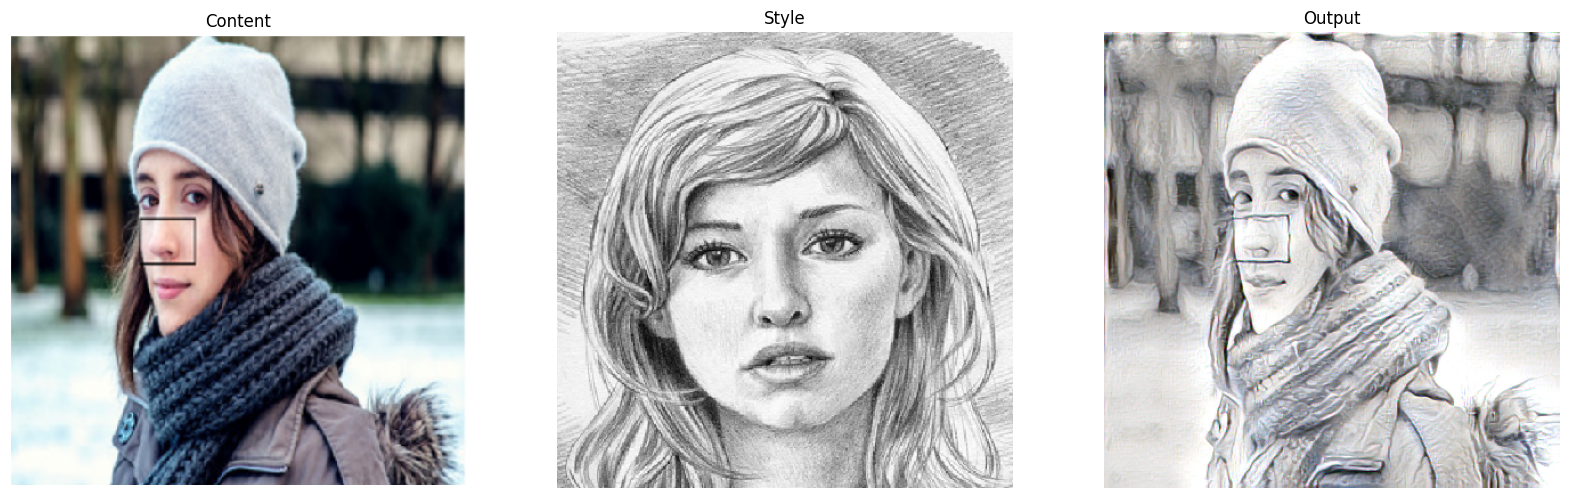

In [18]:
axes = []
fig = plt.figure(figsize=(20, 20))

img = c_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 1))
axes[-1].set_title('Content')
plt.imshow(img)
plt.axis('off')

img = s_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 2))
axes[-1].set_title('Style')
plt.imshow(img)
plt.axis('off')

img = out.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 3))
axes[-1].set_title('Output')
plt.imshow(img)
plt.axis('off')

plt.show()

# Example 2

In [19]:
content_img_path = 'inputs/contents/pyramid.jpg'
style_img_path = 'inputs/styles/tree.jpg'

In [20]:
c = Image.open(content_img_path).convert('RGB')
s = Image.open(style_img_path).convert('RGB')
c = c.resize((400, int(400*c.size[1]/c.size[0])))
s = s.resize((400, int(400*s.size[1]/s.size[0])))
c_tensor = trans(c).unsqueeze(0).to(device)
s_tensor = trans(s).unsqueeze(0).to(device)

In [28]:
model = MultiLevelNetwork(device)
model = model.to('cuda')

In [ ]:
out = model(c_tensor, s_tensor)

In [ ]:
axes = []
fig = plt.figure(figsize=(20, 20))

img = c_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 1))
axes[-1].set_title('Content')
plt.imshow(img)
plt.axis('off')

img = s_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 2))
axes[-1].set_title('Style')
plt.imshow(img)
plt.axis('off')

img = out.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 3))
axes[-1].set_title('Output')
plt.imshow(img)
plt.axis('off')

plt.show()

# Example 3

In [24]:
content_img_path = 'inputs/contents/tomatoes.jpg'
style_img_path = 'inputs/styles/la_muse.jpg'

In [25]:
c = Image.open(content_img_path).convert('RGB')
s = Image.open(style_img_path).convert('RGB')
c = c.resize((400, int(400*c.size[1]/c.size[0])))
s = s.resize((400, int(400*s.size[1]/s.size[0])))
c_tensor = trans(c).unsqueeze(0).to(device)
s_tensor = trans(s).unsqueeze(0).to(device)

In [26]:
model = MultiLevelNetwork(device)
model = model.to('cuda')

In [ ]:
out = model(c_tensor, s_tensor)

In [ ]:
axes = []
fig = plt.figure(figsize=(10, 10))

img = c_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 1))
axes[-1].set_title('Content')
plt.imshow(img)
plt.axis('off')

img = s_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 2))
axes[-1].set_title('Style')
plt.imshow(img)
plt.axis('off')

img = out.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 3))
axes[-1].set_title('Output')
plt.imshow(img)
plt.axis('off')

plt.show()

# Example 4

In [29]:
content_img_path = 'inputs/contents/rock.jpg'
style_img_path = 'inputs/styles/painting.jpg'

In [30]:
c = Image.open(content_img_path).convert('RGB')
s = Image.open(style_img_path).convert('RGB')
c = c.resize((400, int(400*c.size[1]/c.size[0])))
s = s.resize((400, int(400*s.size[1]/s.size[0])))
c_tensor = trans(c).unsqueeze(0).to(device)
s_tensor = trans(s).unsqueeze(0).to(device)

In [31]:
model = MultiLevelNetwork(device)
model = model.to('cuda')
out = model(c_tensor, s_tensor)

In [ ]:
axes = []
fig = plt.figure(figsize=(20, 20))

img = c_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 1))
axes[-1].set_title('Content')
plt.imshow(img)
plt.axis('off')

img = s_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 2))
axes[-1].set_title('Style')
plt.imshow(img)
plt.axis('off')

img = out.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 3))
axes[-1].set_title('Output')
plt.imshow(img)
plt.axis('off')

plt.show()

# Example 5

In [33]:
content_img_path = 'inputs/contents/brad_pitt.jpg'
style_img_path = 'inputs/styles/en_campo_gris.jpg'

In [34]:
c = Image.open(content_img_path).convert('RGB')
s = Image.open(style_img_path).convert('RGB')
c = c.resize((400, int(400*c.size[1]/c.size[0])))
s = s.resize((400, int(400*s.size[1]/s.size[0])))
c_tensor = trans(c).unsqueeze(0).to(device)
s_tensor = trans(s).unsqueeze(0).to(device)

In [35]:
model = MultiLevelNetwork(device)
model = model.to('cuda')
out = model(c_tensor, s_tensor)

In [ ]:
axes = []
fig = plt.figure(figsize=(20, 20))

img = c_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 1))
axes[-1].set_title('Content')
plt.imshow(img)
plt.axis('off')

img = s_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 2))
axes[-1].set_title('Style')
plt.imshow(img)
plt.axis('off')

img = out.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 3))
axes[-1].set_title('Output')
plt.imshow(img)
plt.axis('off')

plt.show()

# Variation of alpha

In [37]:
content_img_path = 'inputs/contents/rock.jpg'
style_img_path = 'inputs/styles/painting.jpg'
alphas = [0.9, 0.5, 0.1]

In [38]:
c = Image.open(content_img_path).convert('RGB')
s = Image.open(style_img_path).convert('RGB')
c = c.resize((400, int(400*c.size[1]/c.size[0])))
s = s.resize((400, int(400*s.size[1]/s.size[0])))
c_tensor = trans(c).unsqueeze(0).to(device)
s_tensor = trans(s).unsqueeze(0).to(device)

In [ ]:
axes = []
fig = plt.figure(figsize=(10, 10))

img = c_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 2, 1))
axes[-1].set_title('Content')
plt.imshow(img)
plt.axis('off')

img = s_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 2, 2))
axes[-1].set_title('Style')
plt.imshow(img)
plt.axis('off')

plt.show()

axes = []
fig = plt.figure(figsize=(20, 20))

for alpha in alphas:
    
    model = MultiLevelNetwork(device, alpha)
    model = model.to('cuda')
    out = model(c_tensor, s_tensor)

    img = out.cpu().squeeze(0).numpy().transpose(1, 2, 0)
    axes.append(fig.add_subplot(1, 3, alphas.index(alpha)+1))
    axes[-1].set_title('alpha = ' + str(alpha))
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Variation of alpha

In [40]:
content_img_path = 'inputs/contents/sailboat.jpg'
style_img_path = 'inputs/styles/mondrian.jpg'
alphas = [i/10 for i in range(11)]

In [41]:
c = Image.open(content_img_path).convert('RGB')
s = Image.open(style_img_path).convert('RGB')
c = c.resize((400, int(400*c.size[1]/c.size[0])))
s = s.resize((400, int(400*s.size[1]/s.size[0])))
c_tensor = trans(c).unsqueeze(0).to(device)
s_tensor = trans(s).unsqueeze(0).to(device)

In [ ]:
axes = []
fig = plt.figure(figsize=(10, 10))

img = c_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 2, 1))
axes[-1].set_title('Content')
plt.imshow(img)
plt.axis('off')

img = s_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 2, 2))
axes[-1].set_title('Style')
plt.imshow(img)
plt.axis('off')

plt.show()

axes = []
fig = plt.figure(figsize=(20, 20))

for alpha in alphas:
    
    model = MultiLevelNetwork(device, alpha)
    model = model.to('cuda')
    out = model(c_tensor, s_tensor)

    img = out.cpu().squeeze(0).numpy().transpose(1, 2, 0)
    axes.append(fig.add_subplot(1, 11, alphas.index(alpha)+1))
    axes[-1].set_title('alpha = ' + str(alpha))
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Variation of beta

In [43]:
content_img_path = 'inputs/contents/sailboat.jpg'
style_img_path = 'inputs/styles/asheville.jpg'
style1_img_path = 'inputs/styles/spiral.jpg'
alpha = 0.1
betas = [i/10 for i in range(11)]

In [44]:
c = Image.open(content_img_path).convert('RGB')
s = Image.open(style_img_path).convert('RGB')
s1 = Image.open(style1_img_path).convert('RGB')
c = c.resize((300, int(300*c.size[1]/c.size[0])))
s = s.resize((300, int(300*s.size[1]/s.size[0])))
s1 = s1.resize((300, int(300*s1.size[1]/s1.size[0])))
c_tensor = trans(c).unsqueeze(0).to(device)
s_tensor = trans(s).unsqueeze(0).to(device)
s1_tensor = trans(s1).unsqueeze(0).to(device)

In [ ]:
axes = []
fig = plt.figure(figsize=(10, 10))

img = c_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 1))
axes[-1].set_title('Content')
plt.imshow(img)
plt.axis('off')

img = s_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 2))
axes[-1].set_title('Style 0')
plt.imshow(img)
plt.axis('off')

img = s1_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 3))
axes[-1].set_title('Style 1')
plt.imshow(img)
plt.axis('off')

plt.show()

axes = []
fig = plt.figure(figsize=(20, 20))

for beta in betas:
    
    model = MultiLevelNetwork(device, alpha, beta)
    model = model.to('cuda')
    out = model(c_tensor, s_tensor, True, s1_tensor)

    img = out.cpu().squeeze(0).numpy().transpose(1, 2, 0)
    axes.append(fig.add_subplot(1, 11, betas.index(beta)+1))
    axes[-1].set_title('beta = ' + str(beta))
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Other Examples

In [46]:
content_img_path = 'inputs/contents/actress.jpg'
style_img_path = 'inputs/styles/golden_gate.jpg'

In [47]:
c = Image.open(content_img_path).convert('RGB')
s = Image.open(style_img_path).convert('RGB')
c = c.resize((400, int(400*c.size[1]/c.size[0])))
s = s.resize((400, int(400*s.size[1]/s.size[0])))
c_tensor = trans(c).unsqueeze(0).to(device)
s_tensor = trans(s).unsqueeze(0).to(device)

In [48]:
model = MultiLevelNetwork(device)
model = model.to('cuda')
out = model(c_tensor, s_tensor)

In [ ]:
axes = []
fig = plt.figure(figsize=(20, 20))

img = c_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 1))
axes[-1].set_title('Content')
plt.imshow(img)
plt.axis('off')

img = s_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 2))
axes[-1].set_title('Style')
plt.imshow(img)
plt.axis('off')

img = out.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 3))
axes[-1].set_title('Output')
plt.imshow(img)
plt.axis('off')

plt.show()

# Other Examples

In [50]:
content_img_path = 'inputs/contents/rock.jpg'
style_img_path = 'inputs/styles/trial.jpg'

In [51]:
c = Image.open(content_img_path).convert('RGB')
s = Image.open(style_img_path).convert('RGB')
c = c.resize((400, int(400*c.size[1]/c.size[0])))
s = s.resize((400, int(400*s.size[1]/s.size[0])))
c_tensor = trans(c).unsqueeze(0).to(device)
s_tensor = trans(s).unsqueeze(0).to(device)

In [52]:
model = MultiLevelNetwork(device)
model = model.to('cuda')
out = model(c_tensor, s_tensor)

In [ ]:
axes = []
fig = plt.figure(figsize=(20, 20))

img = c_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 1))
axes[-1].set_title('Content')
plt.imshow(img)
plt.axis('off')

img = s_tensor.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 2))
axes[-1].set_title('Style')
plt.imshow(img)
plt.axis('off')

img = out.cpu().squeeze(0).numpy().transpose(1, 2, 0)
axes.append(fig.add_subplot(1, 3, 3))
axes[-1].set_title('Output')
plt.imshow(img)
plt.axis('off')

plt.show()